In [2]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import re
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf

%matplotlib inline
os.chdir('/data/arpit.goel/32_RecruitRestarauntPrediction/')

df_air_reserve=pd.read_csv('01.RawData/air_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
df_air_store_info=pd.read_csv('01.RawData/air_store_info.csv')
df_air_visit_data=pd.read_csv('01.RawData/air_visit_data.csv',parse_dates=['visit_date'])
df_date_info=pd.read_csv('01.RawData/date_info.csv',parse_dates=['calendar_date'])
df_hpg_reserve=pd.read_csv('01.RawData/hpg_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
df_hpg_store_info=pd.read_csv('01.RawData/hpg_store_info.csv')
df_store_id_relation=pd.read_csv('01.RawData/store_id_relation.csv')
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_store_master=pd.read_csv('02.CleanData/01.StoreRegion.csv')

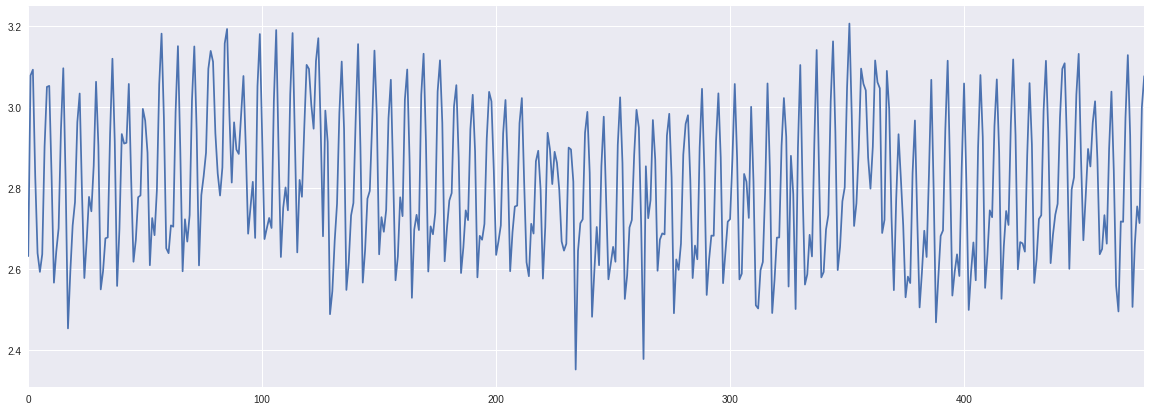

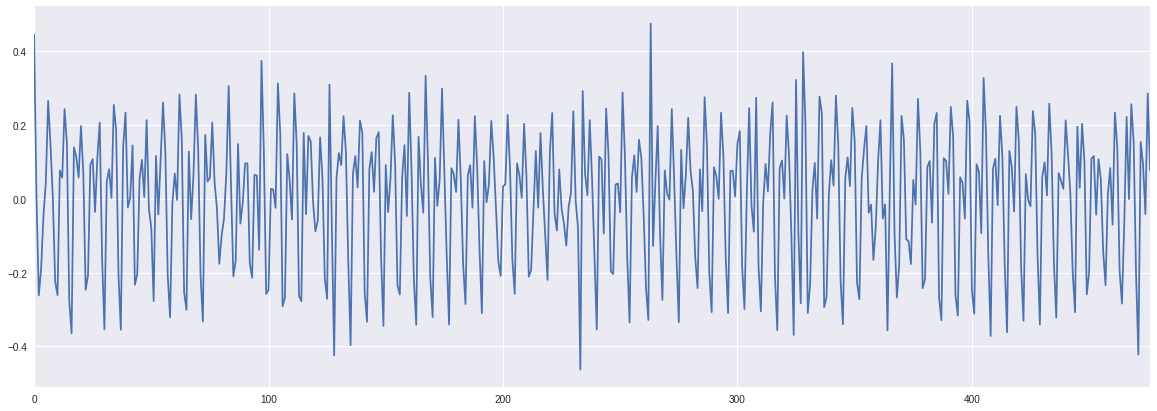

In [3]:
sample=df_air_visit_data[df_air_visit_data['air_store_id']=='air_81a12d67c22e012f']
sample=df_air_visit_data[df_air_visit_data['air_store_id']=='air_00a91d42b08b08d9']
sample.index=sample.visit_date
sample=sample['visitors']
sample=df_air_visit_data.groupby('visit_date')['visitors'].agg(lambda x: np.log(1+x).mean())
plt.figure(figsize=(20,7))
sns.tsplot(sample)
plt.figure(figsize=(20,7))
sns.tsplot(np.diff(sample,1))

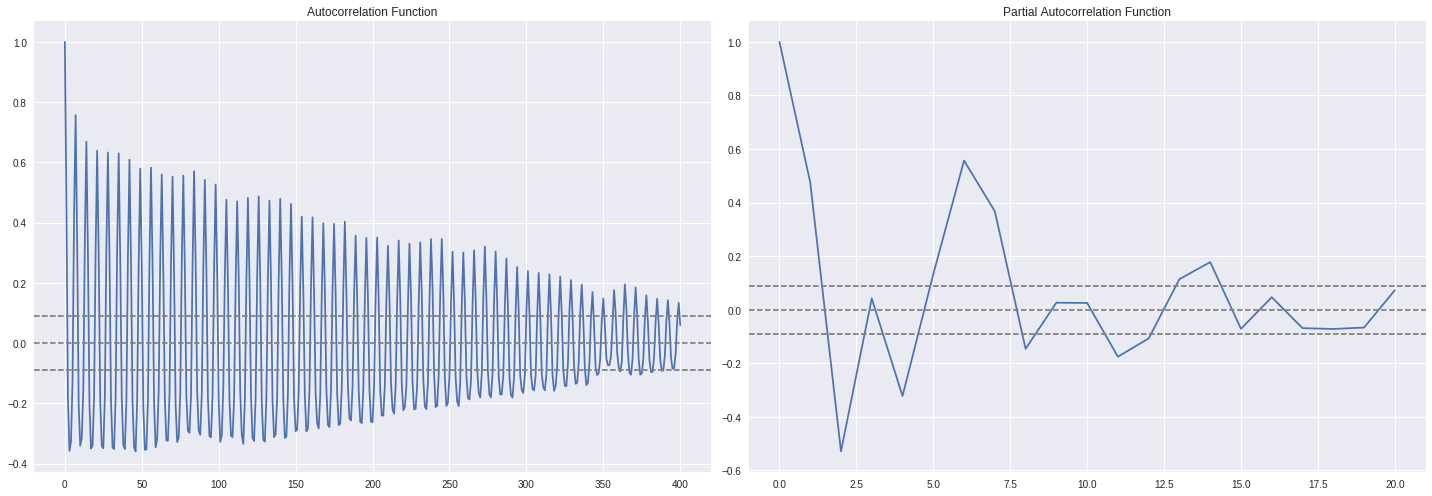

In [5]:
ts_log_diff=sample
lag_acf = acf(ts_log_diff, nlags=400)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,7))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

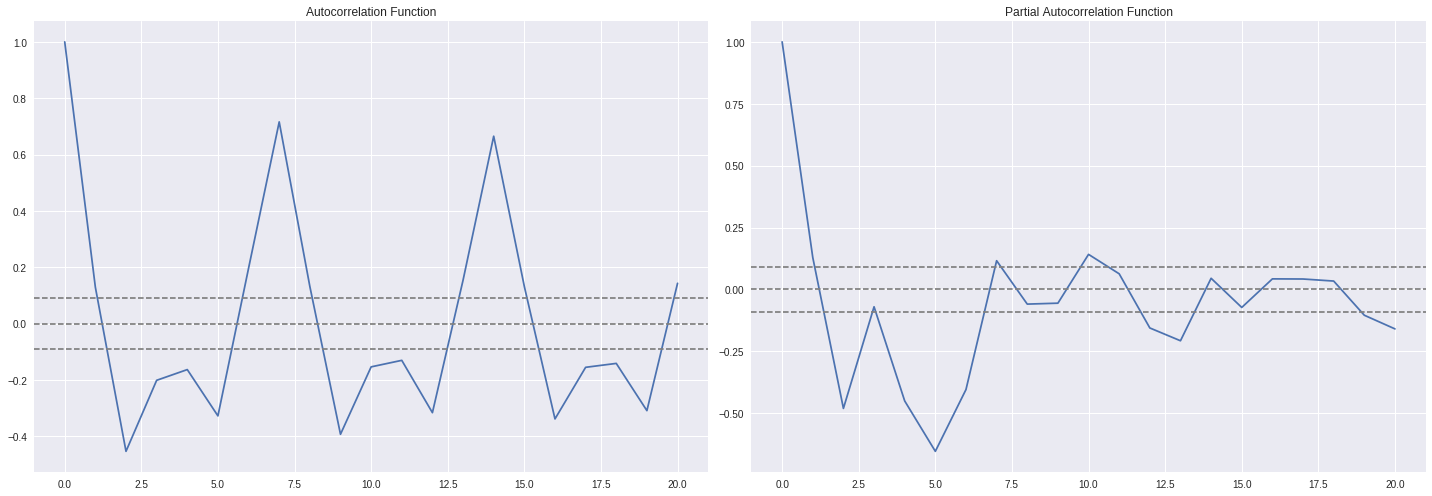

In [27]:
ts_log_diff=np.diff(sample,1)
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,7))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [5]:
from itertools import product
params=[x for x in product(range(8),range(2),range(4))]
print (len(params))

64


In [42]:
model=ARIMA(a[:'2017-01-01'],order=(7,0,3))  
model_fit=model.fit() 
model_fit.forecast(39)[0]

array([ 2.83298985,  2.63914119,  2.6590677 ,  2.76208716,  2.89547177,
        2.82683786,  2.64594643,  2.69358673,  2.68726097,  2.80413439,
        2.78108579,  2.81900445,  2.70918739,  2.71509401,  2.69506003,
        2.77630395,  2.77429299,  2.78946166,  2.73481723,  2.72777701,
        2.71643851,  2.75511691,  2.76621724,  2.77358565,  2.74706333,
        2.73521571,  2.72957408,  2.74754222,  2.75907497,  2.76376719,
        2.75147178,  2.74114301,  2.73708541,  2.74542659,  2.75421149,
        2.75786984,  2.75226841,  2.74501565,  2.74169933])

In [4]:
a=df_air_visit_data[df_air_visit_data['air_store_id']=='air_81a12d67c22e012f']
a.index=a.visit_date
a=np.log(1+a.visitors)
p,d,q=(7,0,3)
sundays=df_date_info[df_date_info['day_of_week']=='Sunday']
sundays=sundays[sundays['calendar_date']<=datetime(2017,4,2)]
sundays=sundays['calendar_date'].tolist()

def train_arima(x,y,params):
    model=ARIMA(x,order=params)  
    model_fit=model.fit() 
    yhat=pd.Series(model_fit.forecast(39)[0],index=pd.date_range(start=x.index.max()+timedelta(days=1),periods=39))
    return mean_squared_error(y,yhat[y.index])
    
def get_training_rmse(x,params):
    rmse=[]
    for sunday in sundays:
        train=x[:sunday+timedelta(days=-1)]
        test=x[sunday:sunday+timedelta(days=38)]
        if len(train)<20 or len(test)<20:
            continue
        print (sunday,np.array(rmse).mean())
        try:
            rmse.append(train_arima(train,test,params))
        except:
            pass
    return np.array(rmse).mean()
    
    
get_training_rmse(a,(7,1,3))

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice.
/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2016-01-31 00:00:00 nan


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-02-07 00:00:00 0.286357825778
2016-02-14 00:00:00 0.286357825778
2016-02-21 00:00:00 2.6174788795


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-02-28 00:00:00 1.82136306641


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-03-06 00:00:00 1.82136306641


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-03-13 00:00:00 1.46681424114


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-03-20 00:00:00 1.25325205887


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-03-27 00:00:00 1.12097738526
2016-04-03 00:00:00 1.12097738526
2016-04-10 00:00:00 1.12097738526


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-04-17 00:00:00 1.01776508928


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-04-24 00:00:00 0.924969438744


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:562: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:227: RuntimeWarning: invalid value encountered in add
  2./hess[i,j]
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy(

2016-05-01 00:00:00 0.924969438744


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-05-08 00:00:00 0.84982422369


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:560: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)


2016-05-15 00:00:00 0.84982422369


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-05-22 00:00:00 0.801538071921


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-05-29 00:00:00 0.766291131885


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-06-05 00:00:00 0.738039430688


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-06-12 00:00:00 0.712774578372


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-06-19 00:00:00 0.689836419869
2016-06-26 00:00:00 0.689836419869


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:492: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:494: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: invalid value

2016-07-03 00:00:00 0.689836419869
2016-07-10 00:00:00 0.689836419869


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-07-17 00:00:00 0.661460954772


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-07-24 00:00:00 0.633558712028


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-07-31 00:00:00 0.610320644387


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-08-07 00:00:00 0.590831671086


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-08-14 00:00:00 0.573682171719


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-08-21 00:00:00 0.559626618456


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


2016-08-28 00:00:00 0.559626618456


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-09-04 00:00:00 0.549787227445


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-09-11 00:00:00 0.538431471596


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-09-18 00:00:00 0.524687058356
2016-09-25 00:00:00 0.524687058356


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-10-02 00:00:00 0.511438799153


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-10-09 00:00:00 0.50559780096


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-10-16 00:00:00 0.500766659421


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-10-23 00:00:00 0.498481342266
2016-10-30 00:00:00 0.498481342266


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-11-06 00:00:00 0.497724082006


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-11-13 00:00:00 0.494304418169


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-11-20 00:00:00 0.488522729862


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-11-27 00:00:00 0.483640641418
2016-12-04 00:00:00 0.483640641418


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-12-11 00:00:00 0.478435185235


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-12-18 00:00:00 0.472044921351


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-12-25 00:00:00 0.462995262024


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-01 00:00:00 0.455377594713


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-08 00:00:00 0.455377594713


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-15 00:00:00 0.447641097005


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 00:00:00 0.443367814207


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-29 00:00:00 0.439118093072


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-05 00:00:00 0.436046665658


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-12 00:00:00 0.431807279524


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 00:00:00 0.428936131761


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 00:00:00 0.425032741884


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-05 00:00:00 0.422103599507


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 00:00:00 0.418631097309


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-19 00:00:00 0.415844574983


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 00:00:00 0.413029102781


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.41103093724124334

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

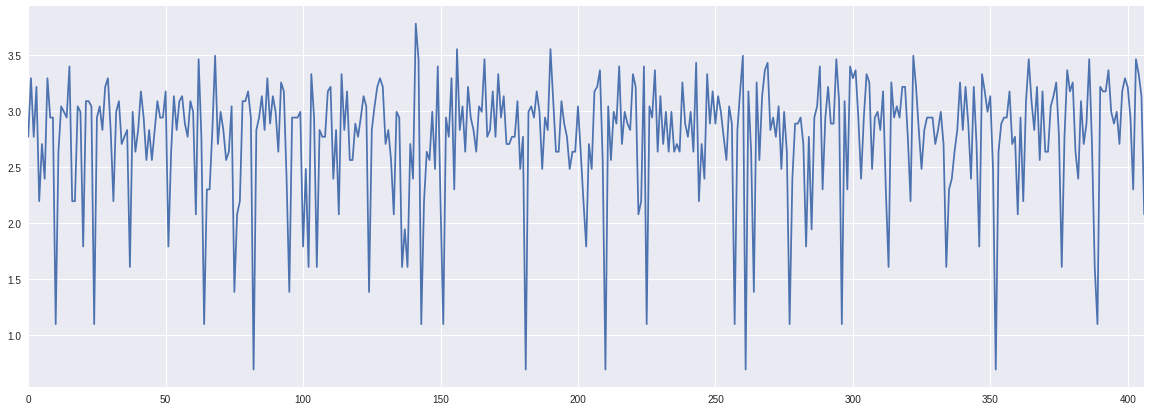

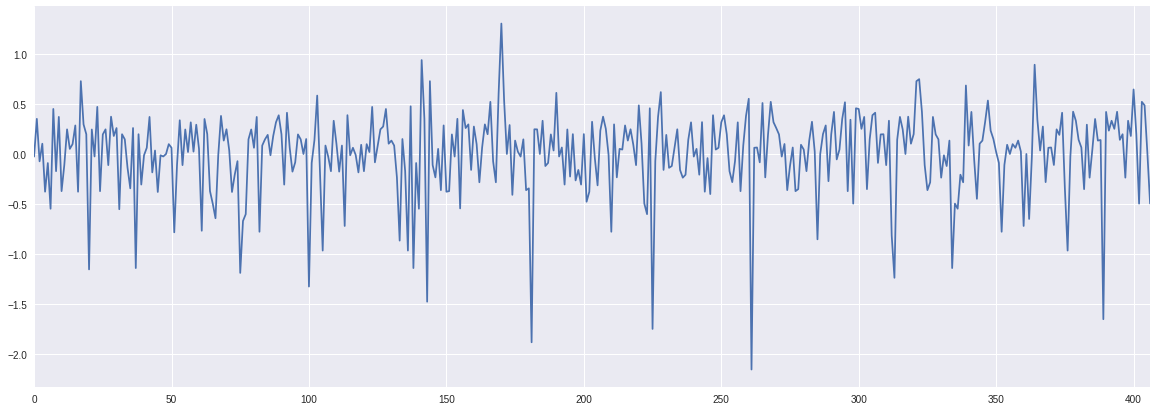

In [23]:
a=df_air_visit_data[df_air_visit_data['air_store_id']=='air_81a12d67c22e012f']
a['visitors']=np.log(1+a['visitors'])
a['weekday']=a['visit_date'].dt.dayofweek
a['weekday_bias']=a.groupby(['weekday'])['visitors'].transform(lambda x: x.mean())
a['visitors_new']=a['visitors']-a['weekday_bias']

plt.figure(figsize=(20,7))
sns.tsplot(a['visitors'])
plt.figure(figsize=(20,7))
sns.tsplot(a['visitors_new'])


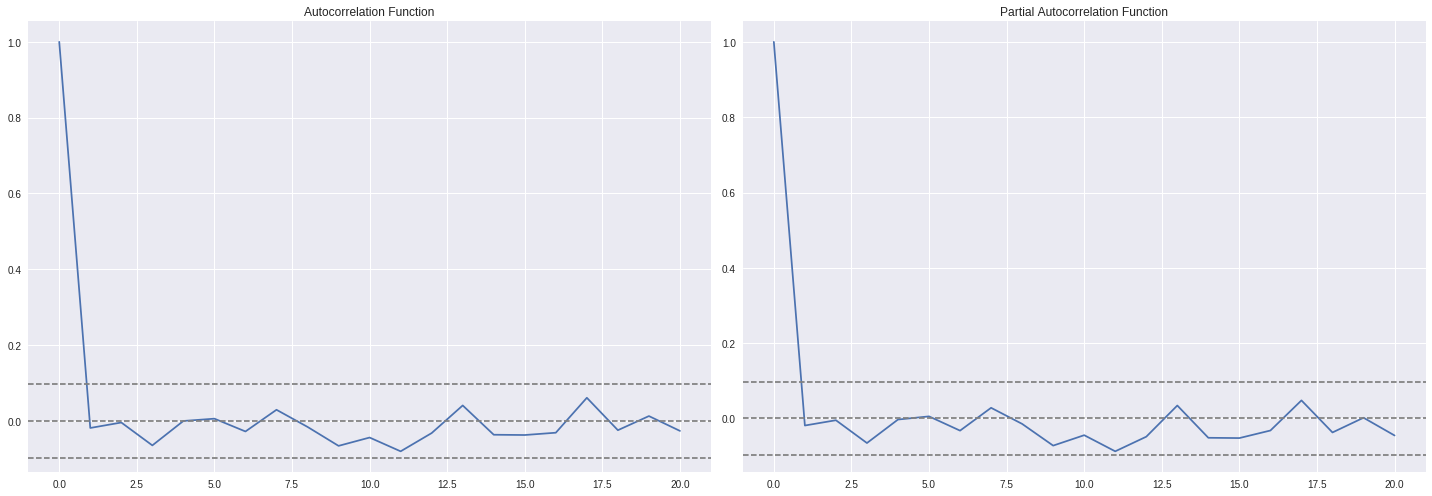

In [24]:
ts_log_diff=a['visitors_new']
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,7))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [29]:
sundays=df_date_info[df_date_info['day_of_week']=='Sunday']
sundays=sundays[sundays['calendar_date']<=datetime(2017,4,2)]
sundays=sundays['calendar_date'].tolist()[::4]
sundays

[Timestamp('2016-01-03 00:00:00'),
 Timestamp('2016-01-31 00:00:00'),
 Timestamp('2016-02-28 00:00:00'),
 Timestamp('2016-03-27 00:00:00'),
 Timestamp('2016-04-24 00:00:00'),
 Timestamp('2016-05-22 00:00:00'),
 Timestamp('2016-06-19 00:00:00'),
 Timestamp('2016-07-17 00:00:00'),
 Timestamp('2016-08-14 00:00:00'),
 Timestamp('2016-09-11 00:00:00'),
 Timestamp('2016-10-09 00:00:00'),
 Timestamp('2016-11-06 00:00:00'),
 Timestamp('2016-12-04 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-29 00:00:00'),
 Timestamp('2017-02-26 00:00:00'),
 Timestamp('2017-03-26 00:00:00')]